In [1]:
import numpy as np
from scipy import stats
from numpy import mean
from numpy.random import beta, poisson
from scipy.special import j_roots
from scipy.special import beta as beta_fun
from matplotlib import pyplot as plt
import pandas as pd

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
test = pd.read_pickle('data/SS3_c57_UMIs_concat_vs_SS3_cast_UMIs_concat_TEST.pkl')
c57 = pd.read_csv('data/SS3_c57_UMIs_concat.csv', index_col=0)
cast = pd.read_csv('data/SS3_cast_UMIs_concat.csv', index_col=0)

In [3]:
# moment-based inference
def MomentInference(vals, export_moments=False):
    # code from Anton Larsson's R implementation
    from scipy import stats # needs imports inside function when run in ipyparallel
    import numpy as np
    m1 = float(np.mean(vals))
    m2 = float(sum(vals*(vals - 1))/len(vals))
    m3 = float(sum(vals*(vals - 1)*(vals - 2))/len(vals))
    
    # sanity check on input (e.g. need at least on expression level)
    if sum(vals) == 0: return np.nan
    if m1 == 0: return np.nan
    if m2 == 0: return np.nan
    
    r1=m1
    r2=m2/m1
    r3=m3/m2
    
    if (r1*r2-2*r1*r3 + r2*r3) == 0: return np.nan
    if ((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3)) == 0: return np.nan
    if (r1 - 2*r2 + r3) == 0: return np.nan
        
    lambda_est = (2*r1*(r3-r2))/(r1*r2-2*r1*r3 + r2*r3)
    mu_est = (2*(r3-r2)*(r1-r3)*(r2-r1))/((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3))
    v_est = (2*r1*r3 - r1*r2 - r2*r3)/(r1 - 2*r2 + r3)
    
    if export_moments:
        return np.array([lambda_est, mu_est, v_est, r1, r2, r3])
    
    return np.array([lambda_est, mu_est, v_est])
def MaximumLikelihood(vals, export_asymp_ci = False, fix = 0, export_fun = False):
    from scipy.interpolate import interp1d
    from scipy.optimize import minimize
    from scipy import special
    from scipy.stats import poisson,norm
    from scipy.special import j_roots
    from scipy.special import beta as beta_fun    
    import numpy as np
    if len(vals) == 0:
        return np.array([np.nan, np.nan, np.nan])
    def dBP(at, alpha, bet, lam):
        at.shape = (len(at), 1)
        np.repeat(at, 50, axis = 1)
        def fun(at, m):
            if(max(m) < 1e6):
                return(poisson.pmf(at,m))
            else:
                return(norm.pdf(at,loc=m,scale=sqrt(m)))
        
        x,w = j_roots(50,alpha = bet - 1, beta = alpha - 1)
        gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
        prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
        return(prob)
    def LogLikelihood(x, vals):
        kon = x[0]
        koff = x[1]
        ksyn = x[2]
        return(-np.sum(np.log( dBP(vals,kon,koff,ksyn) + 1e-10) ) )
    x0 = MomentInference(vals)
    if np.isnan(x0).any():
        x0 = np.array([10,10,10])
    bnds = ((1e-3,1e3),(1e-3,1e3), (1, 1e10))
    vals_ = np.copy(vals) # Otherwise the structure is violated.
    try:
        ll = minimize(LogLikelihood, x0, args = (vals_), method='L-BFGS-B', bounds = bnds)
    except:
        if export_fun:
            return np.array([np.nan,np.nan,np.nan]), np.nan
        return np.array([np.nan,np.nan,np.nan])
    #se = ll.hess_inv.todense().diagonal()
    if export_fun:
        return ll.x, ll.fun
    estim = ll.x
    return estim

In [4]:
cells = 222

In [5]:
def dBP(at, alpha, bet, lam):
    at.shape = (len(at),1)
    np.repeat(at, 50, axis = 1)
    def fun(at, m):
        if(max(m) < 1e6):
            return(stats.poisson.pmf(at,m))
        else:
            return(stats.norm.pdf(at,loc=m,scale=sqrt(m)))
    if alpha <= 0 or bet <= 0:
        return np.nan
    x,w = j_roots(50,alpha = bet-1, beta = alpha - 1)
    gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return(prob)

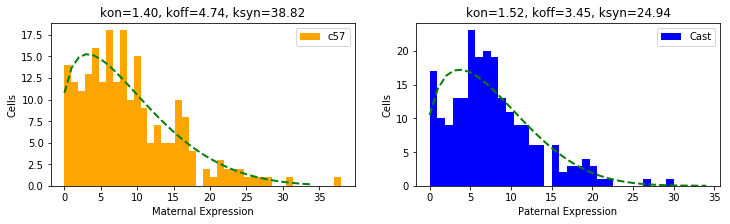

In [6]:
gene = 'Mbnl2'
mat = c57.loc[gene][pd.notnull(c57.loc[gene])]
pat = cast.loc[gene][pd.notnull(cast.loc[gene])]
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
tot_kon,tot_koff, tot_ksyn = test.loc[gene][0]
plt.hist(mat, bins=40, label='c57', color='orange')
plt.plot(cells*dBP(np.arange(35), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.xlabel("Maternal Expression")
plt.ylabel("Cells")
plt.title("kon=%.2f, koff=%.2f, ksyn=%.2f" % (tot_kon, tot_koff, tot_ksyn))
plt.legend(loc='best')
plt.subplot(122)
tot_kon,tot_koff, tot_ksyn = test.loc[gene][1]
plt.hist(pat, bins=32, label='Cast', color='blue')
plt.plot(cells*dBP(np.arange(35), tot_kon, tot_koff, tot_ksyn), 'g--',linewidth=2)
plt.xlabel("Paternal Expression")
plt.ylabel("Cells")
plt.legend(loc='best')
plt.title("kon=%.2f, koff=%.2f, ksyn=%.2f" % (tot_kon, tot_koff, tot_ksyn))
plt.savefig("figures/Fig1a_{}_allelic.pdf".format(gene))
plt.show()

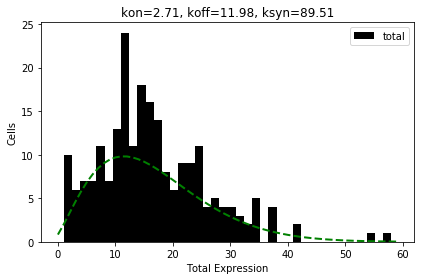

In [7]:
tot_kon, tot_koff, tot_ksyn = MaximumLikelihood(mat+pat)
plt.hist(mat+pat, bins=40, label='total', color='black')
plt.plot(cells*dBP(np.arange(60), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.xlabel("Total Expression")
plt.ylabel("Cells")
plt.title("kon=%.2f, koff=%.2f, ksyn=%.2f" % (tot_kon, tot_koff, tot_ksyn))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('figures/Fig1a_{}_total.pdf'.format(gene))
plt.show()